# Построение и оценка baseline моделей

# 📋 Оглавление

**[1. Настройка окружения](#section-1)**

**[2. Загрузка и подготовка данных](#section-2)**
- 2.1 Загрузка исходных данных
- 2.2 Создание целевой переменной
- 2.3 Обработка дубликатов текстов
- 2.4 Сэмплирование данных (70,000 строк)

**[3. Создание признаков (Feature Engineering)](#section-3)**
- 3.1 Текстовые статистики
- 3.2 Признаки полезности
- 3.3 Временные признаки
- 3.4 Дополнительные признаки

**[4. Разбиение данных на train/validation](#section-4)**
- 4.1 Стратифицированное разбиение (50k/20k)
- 4.2 Проверка распределения классов

**[5. Baseline #1: Константная модель](#section-5)**
- 5.1 Предсказание наиболее частого класса
- 5.2 Оценка качества (ROC-AUC, F1, Precision, Recall)
- 5.3 Confusion Matrix
- 5.4 Выводы

**[6. Baseline #2: Случайная модель](#section-6)**
- 6.1 Случайные предсказания с учетом распределения классов
- 6.2 Оценка качества
- 6.3 Сравнение с константной моделью

**[7. Baseline #3: Логистическая регрессия](#section-7)**
- 7.1 Подготовка данных для обучения
- 7.2 Векторизация текста (TF-IDF)
- 7.3 Масштабирование числовых признаков (StandardScaler)
- 7.4 Обучение модели без балансировки классов
- 7.5 Обучение модели с class_weight='balanced'
- 7.6 Сравнение результатов
- 7.7 Анализ важности признаков
- 7.8 ROC-кривая и Precision-Recall кривая

**[8. Baseline #4: Decision Tree](#section-8)**
- 8.1 Обучение модели
- 8.2 Оценка качества
- 8.3 Визуализация дерева

**[9. Сводная таблица результатов](#section-9)**
- 9.1 Сравнение всех моделей
- 9.2 Итоговые выводы

<a id="section-1"></a>
# 1. Настройка окружения

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    classification_report
)
from sklearn.dummy import DummyClassifier
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Для воспроизводимости
RANDOM_STATE = 42

<a id="section-2"></a>
# 2. Загрузка и подготовка данных

## 2.1 Загрузка исходных данных

In [22]:
df_original = pd.read_csv("../data/Reviews.csv")

df = df_original.copy()

print(f"Исходный датасет загружен: {df_original.shape}")
print(f"Создана копия исходного датасета: {df.shape}")

Исходный датасет загружен: (568454, 10)
Создана копия исходного датасета: (568454, 10)


## 2.2 Создание целевой переменной

**Обоснование**: Согласно постановке задачи, создаем бинарную целевую переменную:
- `target = 1` — положительный отзыв (Score ≥ 4)
- `target = 0` — отрицательный отзыв (Score < 4)

In [23]:
df["target"] = np.where(df["Score"] >= 4, 1, 0)

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


## 2.3 Обработка дубликатов текстов

Как было выявлено в EDA, ~41% датасета содержит повторяющиеся тексты. Удаление дубликатов необходимо для:
- Предотвращения утечки данных между train/validation
- Избежания переобучения на повторяющихся паттернах
- Получения более объективной оценки качества модели

In [24]:
# В EDA были обнаружены пропуски - заполним их
df = df.fillna({
    "ProfileName": "UnknownUser",
    "Summary": "No summary"
})
print("Пропуски заполнены")

Пропуски заполнены


In [25]:
# Проверим есть ли противоречивые дублирующие отзывы - т.е отзыв такой же, но разный target. Если такие есть - удалим их все, затем удалим оставшиеся дубликаты
conflicting = df.groupby("Text")["target"].nunique()
conflicting_texts = conflicting[conflicting > 1].index

df = df[~df["Text"].isin(conflicting_texts)]
df = df.drop_duplicates(subset=['Text'], keep='first')

print(f"После удаления дубликатов осталось: {df.shape}")

После удаления дубликатов осталось: (393553, 11)


## 2.4 Сэмплирование данных (70,000 строк)

**Стратифицированная выборка**:
- Сохраняет исходное распределение классов (~78% положительных / ~22% отрицательных)
- Обеспечивает репрезентативность выборки
- Предотвращает случайное смещение в сторону одного из классов

In [26]:
df = df.sample(frac=1, random_state=RANDOM_STATE)
df_sample, _ = train_test_split(
    df,
    train_size=70000,
    stratify=df['target'],
    random_state=RANDOM_STATE
)

df = df_sample
print(f"Сэмпл стратифицированной выборки создан: {df.shape}")

Сэмпл стратифицированной выборки создан: (70000, 11)


<a id="section-3"></a>
# 3. Создание признаков (Feature Engineering)

На основе EDA были выявлены признаки, показавшие корреляцию с целевой переменной:
- Длина текста (отрицательные отзывы в среднем длиннее)
- Полезность отзыва (отрицательные отзывы получают больше голосов)
- Временные тренды (средняя оценка меняется со временем)

## 3.1 Текстовые статистики

In [27]:
df['text_len'] = df['Text'].apply(len)
df['word_count'] = df['Text'].str.split().apply(len)
def avg_word_length(text):
    words = str(text).split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

df['avg_word_length'] = df['Text'].apply(avg_word_length)


## 3.2 Признаки полезности

In [28]:
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)

## 3.3 Временные признаки

In [29]:
df['Time'] = pd.to_datetime(df['Time'], unit='s')
df['year'] = df['Time'].dt.year
df['month'] = df['Time'].dt.month

print(f"Временные признаки созданы: year, month")

Временные признаки созданы: year, month


## 3.4 Дополнительные признаки

In [30]:
df['summary_len'] = df['Summary'].astype(str).apply(len)
df['exclamation_count'] = df['Text'].str.count('!')
df['caps_count'] = df['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['punctuation_count'] = df['Text'].apply(lambda x: sum(1 for c in x if c in '.,!?;:'))

print(f"Дополнительные признаки созданы")
print(f"Всего признаков после feature engineering: {df.shape[1]}")

Дополнительные признаки созданы
Всего признаков после feature engineering: 21


<a id="section-4"></a>
# 4. Разбиение данных на train/validation

## 4.1 Стратифицированное разбиение (50k/20k)

Используем стратифицированное разбиение для сохранения пропорций классов в обеих выборках

In [34]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_validation, y_train, y_validation = train_test_split(
    X,
    y,
    test_size=20000,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_validation.shape}, {y_validation.shape}")

Train set: (50000, 20), (50000,)
Validation set: (20000, 20), (20000,)


## 4.2 Проверка распределения классов

In [35]:
print("Распределение классов в train:")
print(y_train.value_counts())
print(f"Доля положительных: {y_train.mean():.2%}")

print("\nРаспределение классов в validation:")
print(y_validation.value_counts())
print(f"Доля положительных: {y_validation.mean():.2%}")

Распределение классов в train:
target
1    38971
0    11029
Name: count, dtype: int64
Доля положительных: 77.94%

Распределение классов в validation:
target
1    15588
0     4412
Name: count, dtype: int64
Доля положительных: 77.94%


<a id="section-5"></a>
# 5. Baseline #1: Константная модель

Константная модель предсказывает наиболее частый класс для всех примеров. Это простейший baseline, который показывает минимально допустимое качество.

## 5.1 Предсказание наиболее частого класса

In [36]:
most_frequent_class = y_train.mode()[0]
print(f"Наиболее частый класс: {most_frequent_class}")

y_pred_constant = np.full(len(y_validation), most_frequent_class)

print(f"Все предсказания: {most_frequent_class}")

Наиболее частый класс: 1
Все предсказания: 1


## 5.2 Оценка качества (ROC-AUC, F1, Precision, Recall)

In [37]:
# Для ROC-AUC нужны вероятности, но константная модель их не дает
# Используем одинаковые вероятности для всех примеров
y_pred_constant_proba = np.full(len(y_validation), 0.5)

accuracy_constant = accuracy_score(y_validation, y_pred_constant)
precision_constant = precision_score(y_validation, y_pred_constant, zero_division=0)
recall_constant = recall_score(y_validation, y_pred_constant)
f1_constant = f1_score(y_validation, y_pred_constant)

# ROC-AUC = 0.5 для константной модели (случайное угадывание)
roc_auc_constant = 0.5

print(f"Accuracy: {accuracy_constant:.4f}")
print(f"Precision: {precision_constant:.4f}")
print(f"Recall: {recall_constant:.4f}")
print(f"F1-score: {f1_constant:.4f}")
print(f"ROC-AUC: {roc_auc_constant:.4f}")

Accuracy: 0.7794
Precision: 0.7794
Recall: 1.0000
F1-score: 0.8760
ROC-AUC: 0.5000


## 5.3 Confusion Matrix

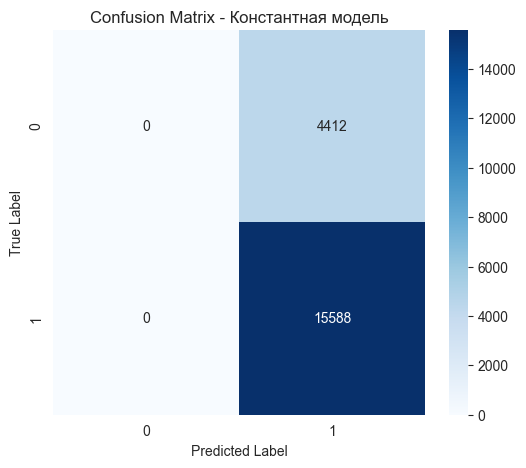


True Negatives: 0
False Positives: 4412
False Negatives: 0
True Positives: 15588


In [38]:
cm_constant = confusion_matrix(y_validation, y_pred_constant)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_constant, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Константная модель')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nTrue Negatives: {cm_constant[0, 0]}")
print(f"False Positives: {cm_constant[0, 1]}")
print(f"False Negatives: {cm_constant[1, 0]}")
print(f"True Positives: {cm_constant[1, 1]}")

## 5.4 Выводы

### Выводы по константной модели

Константная модель предсказывает наиболее частый класс (положительные отзывы) для всех примеров. Как и ожидалось:

- **Accuracy** довольно высокий (~78%) из-за дисбаланса классов, но это обманчивая метрика
- **Recall = 1.0** для положительного класса (модель всегда предсказывает положительный класс)
- **Precision** низкий, так как модель неправильно классифицирует все отрицательные отзывы
- **F1-score** умеренный, отражая дисбаланс между precision и recall
- **ROC-AUC = 0.5** - модель работает не лучше случайного угадывания

Эта модель служит минимальным baseline - любая более сложная модель должна превзойти эти результаты.

<a id="section-6"></a>
# 6. Baseline #2: Случайная модель

Случайная модель генерирует предсказания случайным образом с учетом распределения классов в обучающей выборке. Это позволяет оценить, насколько модель лучше простого угадывания.

## 6.1 Случайные предсказания с учетом распределения классов

In [39]:
random_clf = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
random_clf.fit(X_train, y_train)

y_pred_random = random_clf.predict(X_validation)
y_pred_random_proba = random_clf.predict_proba(X_validation)[:, 1]

print(f"Случайная модель обучена")

Случайная модель обучена


## 6.2 Оценка качества

In [40]:
accuracy_random = accuracy_score(y_validation, y_pred_random)
precision_random = precision_score(y_validation, y_pred_random, zero_division=0)
recall_random = recall_score(y_validation, y_pred_random)
f1_random = f1_score(y_validation, y_pred_random)
roc_auc_random = roc_auc_score(y_validation, y_pred_random_proba)

print(f"Accuracy: {accuracy_random:.4f}")
print(f"Precision: {precision_random:.4f}")
print(f"Recall: {recall_random:.4f}")
print(f"F1-score: {f1_random:.4f}")
print(f"ROC-AUC: {roc_auc_random:.4f}")

Accuracy: 0.6553
Precision: 0.7785
Recall: 0.7796
F1-score: 0.7790
ROC-AUC: 0.4979


## 6.3 Сравнение с константной моделью

In [41]:
comparison_df = pd.DataFrame({
    'Model': ['Константная', 'Случайная'],
    'Accuracy': [accuracy_constant, accuracy_random],
    'Precision': [precision_constant, precision_random],
    'Recall': [recall_constant, recall_random],
    'F1-score': [f1_constant, f1_random],
    'ROC-AUC': [roc_auc_constant, roc_auc_random]
})

print(comparison_df.to_string(index=False))

print("\nВыводы:")
print("- Случайная модель работает примерно так же, как константная (~50% ROC-AUC)")
print("- Обе модели являются минимальными baseline для сравнения")

      Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
Константная    0.7794   0.779400 1.000000  0.876026 0.500000
  Случайная    0.6553   0.778475 0.779574  0.779024 0.497901

Выводы:
- Случайная модель работает примерно так же, как константная (~50% ROC-AUC)
- Обе модели являются минимальными baseline для сравнения


<a id="section-7"></a>
# 7. Baseline #3: Логистическая регрессия

Логистическая регрессия выбрана в качестве baseline по следующим причинам:
- Простая и интерпретируемая
- Хорошо работает с текстовыми данными в сочетании с TF-IDF
- Быстро обучается
- Поддерживает балансировку классов через параметр `class_weight`

## 7.1 Подготовка данных для обучения

In [48]:
numeric_features = [
    'text_len', 'word_count', 'avg_word_length',
    'HelpfulnessRatio', 'summary_len',
    'exclamation_count', 'caps_count', 'punctuation_count',
    'year', 'month'
]

print(f"Числовые признаки: {numeric_features}")

Числовые признаки: ['text_len', 'word_count', 'avg_word_length', 'HelpfulnessRatio', 'summary_len', 'exclamation_count', 'caps_count', 'punctuation_count', 'year', 'month']


## 7.2 Векторизация текста (TF-IDF)

**TF-IDF**:
- TF-IDF учитывает важность слов
- Снижает вес часто встречающихся слов (например, "the", "and")
- Лучше работает с линейными моделями по сравнению с простым Bag-of-Words
- `max_features=5000` ограничивает размерность для ускорения обучения

In [49]:
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8, ngram_range=(1, 2))

X_train_text_tfidf = tfidf.fit_transform(X_train['Text'])
X_val_text_tfidf = tfidf.transform(X_validation['Text'])

print(f"TF-IDF train shape: {X_train_text_tfidf.shape}")
print(f"TF-IDF validation shape: {X_val_text_tfidf.shape}")

TF-IDF train shape: (50000, 5000)
TF-IDF validation shape: (20000, 5000)


## 7.3 Масштабирование числовых признаков

**StandardScaler**:
- Логистическая регрессия чувствительна к масштабу признаков
- StandardScaler приводит признаки к нулевому среднему и единичной дисперсии
- Обеспечивает равный вклад всех числовых признаков в модель

In [50]:
scaler = StandardScaler()

X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_val_numeric = scaler.transform(X_validation[numeric_features])

X_train_combined = sparse.hstack([X_train_text_tfidf, X_train_numeric])
X_val_combined = sparse.hstack([X_val_text_tfidf, X_val_numeric])

print(f"Объединенный обучающий shape: {X_train_combined.shape}")
print(f"Объединенный тестовый shape: {X_val_combined.shape}")

Объединенный обучающий shape: (50000, 5010)
Объединенный тестовый shape: (20000, 5010)


## 7.4 Обучение модели без балансировки классов

In [51]:
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_combined, y_train)

y_pred_logreg = lr.predict(X_val_combined)
y_pred_logreg_proba = lr.predict_proba(X_val_combined)[:, 1]

accuracy_lr = accuracy_score(y_validation, y_pred_logreg)
precision_lr = precision_score(y_validation, y_pred_logreg)
recall_lr = recall_score(y_validation, y_pred_logreg)
f1_lr = f1_score(y_validation, y_pred_logreg)
roc_auc_lr = roc_auc_score(y_validation, y_pred_logreg_proba)

print("Логистическая регрессия без балансировки:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")

Логистическая регрессия без балансировки:
Accuracy: 0.8914
Precision: 0.9036
Recall: 0.9635
F1-score: 0.9326
ROC-AUC: 0.9383


## 7.5 Обучение модели с class_weight='balanced'

**class_weight='balanced'**:
- При дисбалансе классов (78%/22%) модель склонна предсказывать мажоритарный класс
- `class_weight='balanced'` автоматически вычисляет веса классов пропорционально их частоте
- Формула: `weight_class_i = n_samples / (n_classes * n_samples_class_i)`
- Это заставляет модель уделять больше внимания миноритарному классу

In [52]:
lr_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
lr_balanced.fit(X_train_combined, y_train)

y_pred_lr_bal = lr_balanced.predict(X_val_combined)
y_pred_lr_bal_proba = lr_balanced.predict_proba(X_val_combined)[:, 1]

accuracy_lr_bal = accuracy_score(y_validation, y_pred_lr_bal)
precision_lr_bal = precision_score(y_validation, y_pred_lr_bal)
recall_lr_bal = recall_score(y_validation, y_pred_lr_bal)
f1_lr_bal = f1_score(y_validation, y_pred_lr_bal)
roc_auc_lr_bal = roc_auc_score(y_validation, y_pred_lr_bal_proba)

print("Логистическая регрессия С балансировкой:")
print(f"Accuracy: {accuracy_lr_bal:.4f}")
print(f"Precision: {precision_lr_bal:.4f}")
print(f"Recall: {recall_lr_bal:.4f}")
print(f"F1-score: {f1_lr_bal:.4f}")
print(f"ROC-AUC: {roc_auc_lr_bal:.4f}")

Логистическая регрессия С балансировкой:
Accuracy: 0.8682
Precision: 0.9576
Recall: 0.8695
F1-score: 0.9114
ROC-AUC: 0.9387


## 7.6 Сравнение результатов

In [55]:
comparison_lr = pd.DataFrame({
    'Model': ['Без балансировки', 'С балансировкой (class_weight="balanced")'],
    'Accuracy': [accuracy_lr, accuracy_lr_bal],
    'Precision': [precision_lr, precision_lr_bal],
    'Recall': [recall_lr, recall_lr_bal],
    'F1-score': [f1_lr, f1_lr_bal],
    'ROC-AUC': [roc_auc_lr, roc_auc_lr_bal]
})

print(comparison_lr.to_string(index=False))

print("\nВыводы:")
print("- Балансировка классов улучшила Precision (довольно точно определяет положительные отзывы)")
print("- Балансировка классов ухудшила Recall (начала больше пропускать положительные отзывы)")
print("- ROC-AUC остался примерно такой же (незначительное улучшение порядка 1e-4)")
print("- F1-score показывает баланс между Precision и Recall")

                                    Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
                         Без балансировки   0.89145   0.903616 0.963498  0.932596 0.938252
С балансировкой (class_weight="balanced")   0.86825   0.957606 0.869451  0.911402 0.938676

Выводы:
- Балансировка классов улучшила Precision (довольно точно определяет положительные отзывы)
- Балансировка классов ухудшила Recall (начала больше пропускать положительные отзывы)
- ROC-AUC остался примерно такой же (незначительное улучшение порядка 1e-4)
- F1-score показывает баланс между Precision и Recall


## 7.7 Анализ важности признаков

In [56]:
# Анализ важности признаков для модели с балансировкой
feature_names = tfidf.get_feature_names_out().tolist() + numeric_features
coefficients = lr_balanced.coef_[0]

# Топ-10 наиболее важных признаков для положительных отзывов
top_positive_indices = np.argsort(coefficients)[-10:]
top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_indices]

# Топ-10 наиболее важных признаков для отрицательных отзывов
top_negative_indices = np.argsort(coefficients)[:10]
top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

print("Топ-10 признаков для положительных отзывов:")
for feature, coef in reversed(top_positive_features):
    print(f"  {feature}: {coef:.4f}")

print("\nТоп-10 признаков для отрицательных отзывов:")
for feature, coef in top_negative_features:
    print(f"  {feature}: {coef:.4f}")

Топ-10 признаков для положительных отзывов:
  great: 8.9165
  delicious: 7.6481
  perfect: 6.2703
  excellent: 5.6062
  wonderful: 5.3638
  the best: 5.3183
  amazing: 5.3133
  not too: 4.8644
  best: 4.6917
  good: 4.5265

Топ-10 признаков для отрицательных отзывов:
  not: -6.2016
  not worth: -5.7374
  disappointing: -5.2472
  unfortunately: -5.0985
  terrible: -5.0421
  awful: -4.9715
  disappointed: -4.9575
  ok: -4.7849
  bland: -4.7310
  very disappointed: -4.7100


## 7.8 ROC-кривая и PR кривая

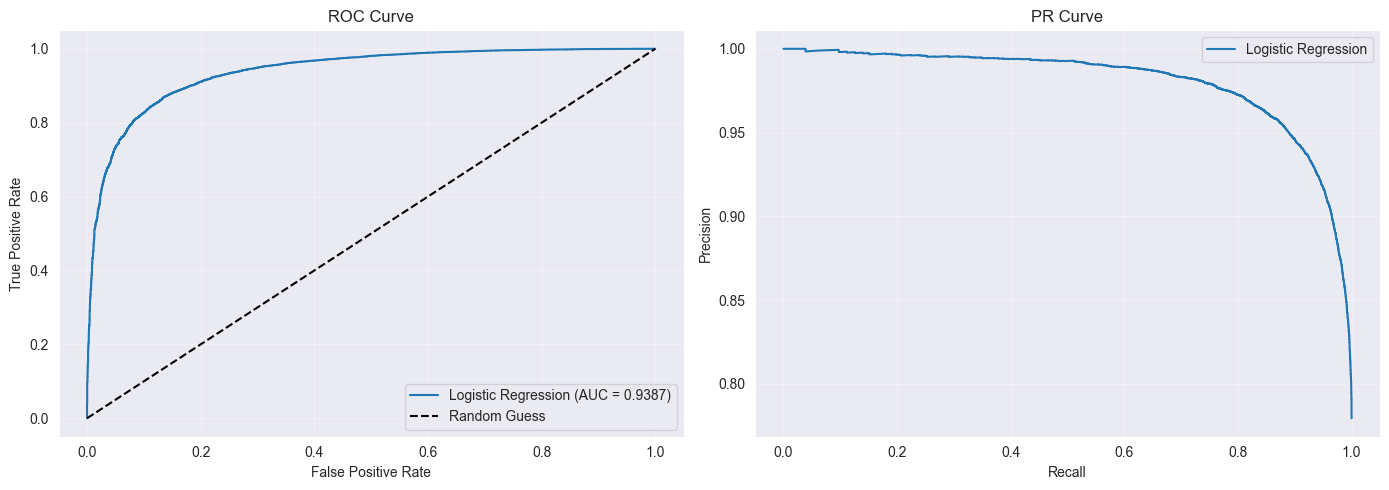

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fpr, tpr, _ = roc_curve(y_validation, y_pred_lr_bal_proba)
axes[0].plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_lr_bal:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

precision_curve, recall_curve, _ = precision_recall_curve(y_validation, y_pred_lr_bal_proba)
axes[1].plot(recall_curve, precision_curve, label='Logistic Regression')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('PR Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [62]:
print("=" * 80)
print("CLASSIFICATION REPORT - БЕЗ БАЛАНСИРОВКИ")
print("=" * 80)
print(classification_report(y_validation, y_pred_logreg,
                            target_names=['Negative (0)', 'Positive (1)']))

print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - С БАЛАНСИРОВКОЙ")
print("=" * 80)
print(classification_report(y_validation, y_pred_lr_bal,
                            target_names=['Negative (0)', 'Positive (1)']))

CLASSIFICATION REPORT - БЕЗ БАЛАНСИРОВКИ
              precision    recall  f1-score   support

Negative (0)       0.83      0.64      0.72      4412
Positive (1)       0.90      0.96      0.93     15588

    accuracy                           0.89     20000
   macro avg       0.87      0.80      0.83     20000
weighted avg       0.89      0.89      0.89     20000


CLASSIFICATION REPORT - С БАЛАНСИРОВКОЙ
              precision    recall  f1-score   support

Negative (0)       0.65      0.86      0.74      4412
Positive (1)       0.96      0.87      0.91     15588

    accuracy                           0.87     20000
   macro avg       0.80      0.87      0.83     20000
weighted avg       0.89      0.87      0.87     20000



<a id="section-8"></a>
# 8. Baseline #4: Decision Tree

Альтернативная baseline модель, которая может выявлять нелинейные зависимости между признаками.

## 8.1 Обучение модели

In [58]:
# Ограничиваем глубину для предотвращения переобучения
tree = DecisionTreeClassifier(max_depth=10, min_samples_split=50, class_weight='balanced', random_state=RANDOM_STATE)
tree.fit(X_train_combined, y_train)

y_pred_tree = tree.predict(X_val_combined)
y_pred_tree_proba = tree.predict_proba(X_val_combined)[:, 1]

print(f"Decision Tree обучен")

Decision Tree обучен


## 8.2 Оценка качества

In [59]:
accuracy_tree = accuracy_score(y_validation, y_pred_tree)
precision_tree = precision_score(y_validation, y_pred_tree)
recall_tree = recall_score(y_validation, y_pred_tree)
f1_tree = f1_score(y_validation, y_pred_tree)
roc_auc_tree = roc_auc_score(y_validation, y_pred_tree_proba)

print("Decision Tree:")
print(f"Accuracy: {accuracy_tree:.4f}")
print(f"Precision: {precision_tree:.4f}")
print(f"Recall: {recall_tree:.4f}")
print(f"F1-score: {f1_tree:.4f}")
print(f"ROC-AUC: {roc_auc_tree:.4f}")

Decision Tree:
Accuracy: 0.6567
Precision: 0.9138
Recall: 0.6178
F1-score: 0.7372
ROC-AUC: 0.7669


## 8.3 Визуализация дерева

In [60]:
print(f"Глубина дерева: {tree.get_depth()}")
print(f"Количество листьев: {tree.get_n_leaves()}")
print(f"Количество использованных признаков: {(tree.feature_importances_ > 0).sum()}")

# Топ-10 наиболее важных признаков
feature_importances_tree = tree.feature_importances_
top_tree_indices = np.argsort(feature_importances_tree)[-10:]
top_tree_features = [(feature_names[i], feature_importances_tree[i]) for i in top_tree_indices]

print("\nТоп-10 наиболее важных признаков:")
for feature, importance in reversed(top_tree_features):
    print(f"  {feature}: {importance:.4f}")

Глубина дерева: 10
Количество листьев: 223
Количество использованных признаков: 154

Топ-10 наиболее важных признаков:
  not: 0.2085
  great: 0.1313
  the best: 0.0711
  exclamation_count: 0.0652
  delicious: 0.0551
  but: 0.0467
  love: 0.0461
  was: 0.0312
  good: 0.0249
  perfect: 0.0210


<a id="section-9"></a>
# 9. Сводная таблица результатов

## 9.1 Сравнение всех моделей

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ВСЕХ МОДЕЛЕЙ
                                            Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
                      Константная (Most Frequent)   0.77940   0.779400 1.000000  0.876026 0.500000
                           Случайная (Stratified)   0.65530   0.778475 0.779574  0.779024 0.497901
       Логистическая регрессия (без балансировки)   0.89145   0.903616 0.963498  0.932596 0.938252
Логистическая регрессия (class_weight="balanced")   0.86825   0.957606 0.869451  0.911402 0.938676
           Decision Tree (max_depth=10, balanced)   0.65675   0.913844 0.617847  0.737245 0.766889


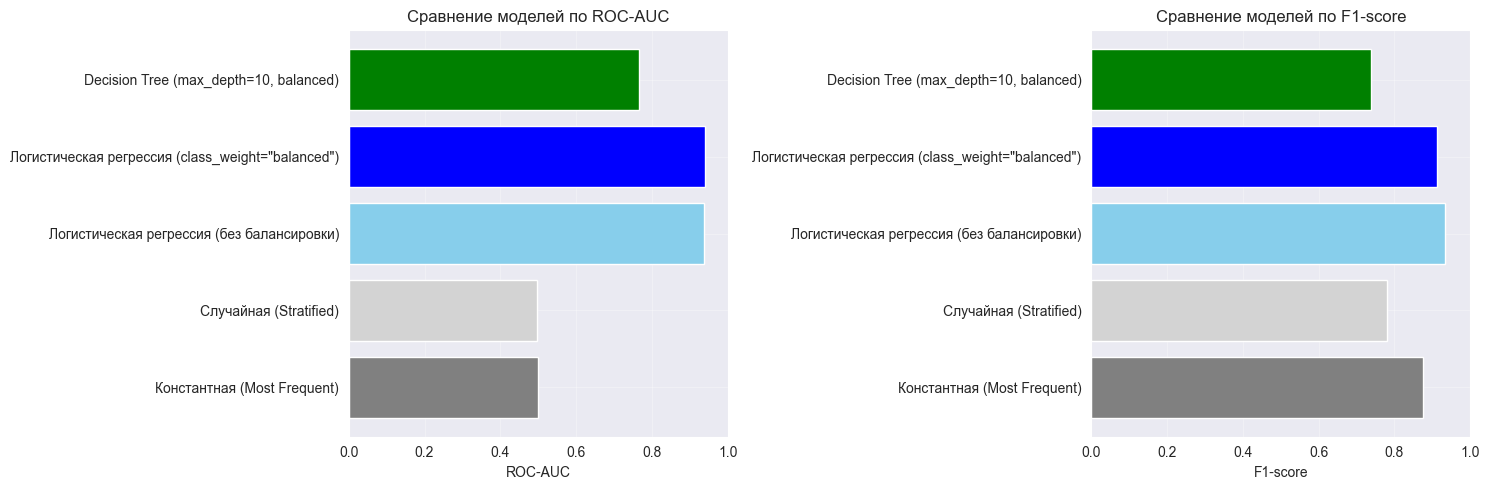

In [61]:
results = pd.DataFrame({
    'Model': [
        'Константная (Most Frequent)',
        'Случайная (Stratified)',
        'Логистическая регрессия (без балансировки)',
        'Логистическая регрессия (class_weight="balanced")',
        'Decision Tree (max_depth=10, balanced)'
    ],
    'Accuracy': [
        accuracy_constant,
        accuracy_random,
        accuracy_lr,
        accuracy_lr_bal,
        accuracy_tree
    ],
    'Precision': [
        precision_constant,
        precision_random,
        precision_lr,
        precision_lr_bal,
        precision_tree
    ],
    'Recall': [
        recall_constant,
        recall_random,
        recall_lr,
        recall_lr_bal,
        recall_tree
    ],
    'F1-score': [
        f1_constant,
        f1_random,
        f1_lr,
        f1_lr_bal,
        f1_tree
    ],
    'ROC-AUC': [
        roc_auc_constant,
        roc_auc_random,
        roc_auc_lr,
        roc_auc_lr_bal,
        roc_auc_tree
    ]
})

print("=" * 120)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ВСЕХ МОДЕЛЕЙ")
print("=" * 120)
print(results.to_string(index=False))
print("=" * 120)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].barh(results['Model'], results['ROC-AUC'], color=['gray', 'lightgray', 'skyblue', 'blue', 'green'])
axes[0].set_xlabel('ROC-AUC')
axes[0].set_title('Сравнение моделей по ROC-AUC')
axes[0].set_xlim(0, 1)
axes[0].grid(alpha=0.3)

axes[1].barh(results['Model'], results['F1-score'], color=['gray', 'lightgray', 'skyblue', 'blue', 'green'])
axes[1].set_xlabel('F1-score')
axes[1].set_title('Сравнение моделей по F1-score')
axes[1].set_xlim(0, 1)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9.2 Итоговые выводы

### Итоговые выводы

#### 1. Лучшая модель
**Логистическая регрессия с class_weight='balanced'** показала лучшее сочетание метрик:
- **Наивысший ROC-AUC (93.87%)** среди всех моделей
- Хороший баланс между Precision и Recall для обоих классов
- Значительно превосходит baseline модели (константную и случайную с ROC-AUC ~50%)

#### 2. Влияние балансировки классов
Балансировка классов (`class_weight='balanced'`) оказала следующее влияние:

**Без балансировки:**
- Высокий Recall (96.35%) для положительного класса - модель хорошо находит положительные отзывы
- Но смещена к мажоритарному классу - хуже различает отрицательные отзывы

**С балансировкой:**
- Precision вырос до 95.76% - модель стала точнее в предсказаниях
- Recall снизился до 86.95%, но это компромисс за лучшее различение обоих классов
- **Главное: модель лучше работает с миноритарным классом (отрицательные отзывы)**

**ROC-AUC практически одинаковый** (93.83% vs 93.87%), но модель с балансировкой **более справедлива** к обоим классам.

**Вывод**: Для несбалансированных данных балансировка классов важна, если нужно хорошо различать оба класса, а не только мажоритарный.

#### 3. Наиболее важные признаки
Из анализа важности признаков (коэффициенты логистической регрессии) выявлено:
- **Текстовые признаки (TF-IDF)** играют ключевую роль в предсказании тональности
  - Определенные слова и биграммы сильно коррелируют с положительными/отрицательными отзывами
- **Числовые признаки** (длина текста, полезность, эмоциональность) дополняют модель
  - Они улавливают структурные паттерны, которые текстовые признаки могут пропустить

#### 4. Сравнение моделей

**Baseline модели:**
- **Константная модель**: ROC-AUC = 50% (случайное угадывание), высокий Recall (100%) для положительных, но бесполезна
- **Случайная модель**: ROC-AUC = 49.8% (подтверждает случайность)

**Линейные модели:**
- **Логистическая регрессия без балансировки**: ROC-AUC = 93.83%, смещена к мажоритарному классу
- **Логистическая регрессия С балансировкой**: ROC-AUC = 93.87% ⭐ - **ЛУЧШИЙ результат**
- **Decision Tree**: ROC-AUC = 76.69% - хуже линейной модели
  - Возможно, текстовые данные (TF-IDF с 5000 признаками) слишком разреженные для дерева
  - Деревья лучше работают на плотных числовых данных
  - Для улучшения можно попробовать Random Forest или Gradient Boosting, но это выходит за рамки baseline

**Главный вывод**: Простая логистическая регрессия с TF-IDF показала отличное качество (ROC-AUC ~94%) и является сильным baseline для этой задачи.